Here, we examine functional sensitivity of the structure model on a small simulated dataset

In [37]:
import jax

import jax.numpy as np
import jax.scipy as sp
from numpy.polynomial.hermite import hermgauss

from vb_lib import structure_model_lib, data_utils, cavi_lib, plotting_utils
import vb_lib.structure_optimization_lib as s_optim_lib
from vb_lib.preconditioner_lib import get_mfvb_cov_matmul
from bnpmodeling_runjingdev.sensitivity_lib import HyperparameterSensitivityLinearApproximation

import paragami

from copy import deepcopy

import time

import matplotlib.pyplot as plt
%matplotlib inline  

from bnpmodeling_runjingdev import cluster_quantities_lib, modeling_lib
import bnpmodeling_runjingdev.functional_sensitivity_lib as func_sens_lib


In [2]:
import numpy as onp 
onp.random.seed(53453)

# Draw data

In [3]:
data_file = '../simulated_data/simulated_structure_data_nobs20_nloci50_npop4.npz'
data = np.load(data_file)

# the observations
g_obs = np.array(data['g_obs'], dtype = int)

n_obs = g_obs.shape[0]
n_loci = g_obs.shape[1]

# the ground truth 
true_ind_admix_propn = data['true_ind_admix_propn']

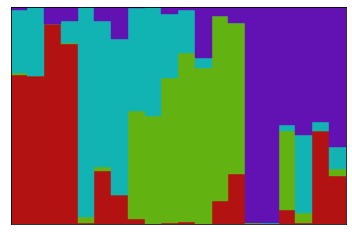

In [4]:
fig, axarr = plt.subplots(1, 1)
plotting_utils.plot_admixture(true_ind_admix_propn, axarr);

# Get prior

In [5]:
prior_params_dict, prior_params_paragami = \
    structure_model_lib.get_default_prior_params()

print(prior_params_paragami)

prior_params_free = prior_params_paragami.flatten(prior_params_dict, free = True)

OrderedDict:
	[dp_prior_alpha] = NumericArrayPattern (1,) (lb=0.0, ub=inf)
	[allele_prior_alpha] = NumericArrayPattern (1,) (lb=0.0, ub=inf)
	[allele_prior_beta] = NumericArrayPattern (1,) (lb=0.0, ub=inf)


In [6]:
print(prior_params_dict)

{'dp_prior_alpha': DeviceArray([3.], dtype=float64), 'allele_prior_alpha': DeviceArray([1.], dtype=float64), 'allele_prior_beta': DeviceArray([1.], dtype=float64)}


# Get VB params 

In [7]:
k_approx = 15

In [8]:
gh_deg = 8
gh_loc, gh_weights = hermgauss(8)

In [9]:
use_logitnormal_sticks = True

vb_params_dict, vb_params_paragami = \
    structure_model_lib.get_vb_params_paragami_object(n_obs, n_loci, k_approx,
                                    use_logitnormal_sticks = use_logitnormal_sticks)
    
print(vb_params_paragami)

OrderedDict:
	[pop_freq_beta_params] = NumericArrayPattern (50, 15, 2) (lb=0.0, ub=inf)
	[ind_admix_params] = OrderedDict:
	[stick_means] = NumericArrayPattern (20, 14) (lb=-inf, ub=inf)
	[stick_infos] = NumericArrayPattern (20, 14) (lb=0.0001, ub=inf)


## Initialize 

In [10]:
vb_params_dict = \
        s_optim_lib.set_init_vb_params(g_obs, k_approx, vb_params_dict,
                                       prior_params_dict, 
                                       gh_loc, gh_weights,
                                       seed = 34221)

running NMF ...
running a few cavi steps for pop beta ...
done. Elapsed: 6.36399


# Optimize

In [11]:
from vb_lib.structure_optimization_lib import define_structure_objective
from bnpmodeling_runjingdev.optimization_lib import run_lbfgs

In [12]:
optim_objective, init_vb_free = \
    define_structure_objective(g_obs, vb_params_dict,
                        vb_params_paragami,
                        prior_params_dict,
                        gh_loc = gh_loc,
                        gh_weights = gh_weights, 
                        compile_hvp=False)


Compiling objective ...
Iter 0: f = 2649.80027944
Compiling grad ...
Compile time: 13.0288secs


In [13]:
out = run_lbfgs(optim_objective, init_vb_free)

vb_opt = out.x
vb_opt_dict = vb_params_paragami.fold(vb_opt, free = True)



Running L-BFGS-B ... 
Iter 0: f = 2649.80027944
Iter 1: f = 2598.72662706
Iter 2: f = 2429.98449137
Iter 3: f = 2215.09446543
Iter 4: f = 2172.51855120
Iter 5: f = 2128.22542216
Iter 6: f = 2109.04048577
Iter 7: f = 2097.68655302
Iter 8: f = 2084.22580864
Iter 9: f = 2062.57361836
Iter 10: f = 3118.52269311
Iter 11: f = 2055.83801356
Iter 12: f = 2038.38357807
Iter 13: f = 2019.12416478
Iter 14: f = 1981.92884239
Iter 15: f = 1950.52627517
Iter 16: f = 1932.19338483
Iter 17: f = 1917.96007706
Iter 18: f = 1908.09165508
Iter 19: f = 1898.29864704
Iter 20: f = 1887.97459621
Iter 21: f = 1880.04413778
Iter 22: f = 1872.53542887
Iter 23: f = 1868.79083225
Iter 24: f = 1864.02600484
Iter 25: f = 1860.06376122
Iter 26: f = 1853.29145336
Iter 27: f = 1848.12843031
Iter 28: f = 1845.52800570
Iter 29: f = 1843.39777796
Iter 30: f = 1842.52447319
Iter 31: f = 1841.95575664
Iter 32: f = 1841.60306624
Iter 33: f = 1841.31770810
Iter 34: f = 1841.05169490
Iter 35: f = 1840.85032325
Iter 36: f = 18

# Check out the fit

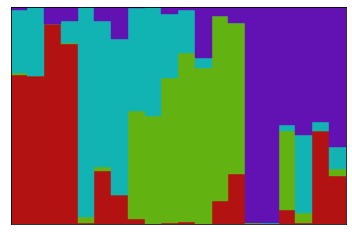

In [14]:
# truth
fig, axarr = plt.subplots(1, 1)
plotting_utils.plot_admixture(true_ind_admix_propn, axarr);

Text(0.5, 0, 'individual')

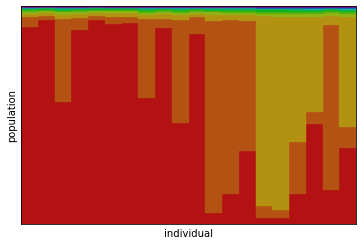

In [15]:
# estimated 

e_ind_admix = plotting_utils.get_vb_expectations(vb_opt_dict, gh_loc, gh_weights)[0]

fig, axarr = plt.subplots(1, 1)
plotting_utils.plot_admixture(e_ind_admix, axarr);

plt.ylabel('population')
plt.xlabel('individual')

# Set up linear response derivatives

In [17]:
# set up objective functions

# this just returns the KL at epsilon = 0 
# (no perturbation)
# NOTE this function doesn't actually depend on epsilon
# we can do this and set log_phi later because 
# the perturbation is multiplicative 
# (so the hessian at epsilon = 0 does not depend on the perturbation)
get_vb_loss = paragami.FlattenFunctionInput(
    lambda params, epsilon: structure_model_lib.get_kl(g_obs, 
                                            params,
                                            prior_params_dict, 
                                            gh_loc,
                                            gh_weights),
    argnums=0, patterns=vb_params_paragami, free=True)


# this is just a place holder for a null perturbation
# will set this properly later
hyper_par_objective_fun = lambda params, epsilon: 0.


In [18]:
# set up linear approximation class
epsilon0 = np.array([0.])

epsilon_sens = \
    HyperparameterSensitivityLinearApproximation(
        objective_fun = get_vb_loss, 
        opt_par_value = vb_opt, 
        hyper_par_value0 = epsilon0, 
        hyper_par_objective_fun = hyper_par_objective_fun)


Compiling ...
Compile time: 83.1393sec



# Compute influence function

In [19]:
import bnpgmm_runjingdev.gmm_stick_influence_lib as gmm_influence_lib

In [20]:
# the influence function
influence_operator = gmm_influence_lib.InfluenceOperator(vb_opt, 
                           vb_params_paragami, 
                           epsilon_sens.hessian_solver,
                           prior_params_dict['dp_prior_alpha'], 
                           stick_key = 'ind_admix_params')

### Define posterior quantity of interest

In [21]:
def g(vb_free_params, vb_params_paragami): 
    
    # key for random sampling. 
    # this is fixed! so all standard normal 
    # samples used in computing the posterior quantity 
    key = jax.random.PRNGKey(0)
    
    vb_params_dict = vb_params_paragami.fold(vb_free_params, free = True)
    
    stick_means = vb_params_dict['ind_admix_params']['stick_means']
    stick_infos = vb_params_dict['ind_admix_params']['stick_infos']
    
    return structure_model_lib.get_e_num_pred_clusters(stick_means, stick_infos, gh_loc, gh_weights, 
                                                            key, n_samples = 10000)

In [22]:
get_grad_g = jax.jacobian(g, argnums = 0)
grad_g = get_grad_g(vb_opt, vb_params_paragami)

### worst-case influence

In [24]:
influence_fun = lambda logit_v : np.dot(grad_g,
                                        influence_operator.get_influence(logit_v))

In [23]:
worst_case_pert = gmm_influence_lib.WorstCasePerturbation(influence_fun)

### Plot influence function

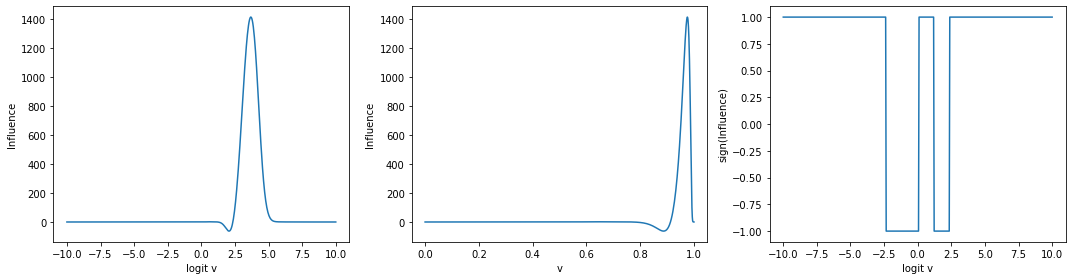

In [29]:
fig, ax = plt.subplots(1, 3, figsize = (15, 4)) 
ax[0].plot(worst_case_pert.logit_v_grid, worst_case_pert.influence_grid)
ax[0].set_xlabel('logit v')
ax[0].set_ylabel('Influence')

ax[1].plot(worst_case_pert.v_grid, worst_case_pert.influence_grid)
ax[1].set_xlabel('v')
ax[1].set_ylabel('Influence')

ax[2].plot(worst_case_pert.logit_v_grid, np.sign(worst_case_pert.influence_grid))
ax[2].set_xlabel('logit v')
ax[2].set_ylabel('sign(Influence)')

fig.tight_layout()

# Define prior perturbation

In [32]:
# just for plotting only! 
# saves some time in computing the influence function
# by doing a setp function interpolation
def influence_fun_interp(logit_v): 
    # find index of logit_v_grid 
    # closest (on the left) to logit_v
    indx = np.searchsorted(worst_case_pert.logit_v_grid, logit_v)
    
    # return the influence function at those points
    return worst_case_pert.influence_grid[indx]

# define log phi
def log_phi(logit_v):
    return(np.sign(influence_fun_interp(logit_v)))

In [40]:
prior_perturbation = func_sens_lib.PriorPerturbation(
                                alpha0 = prior_params_dict['dp_prior_alpha'],
                                log_phi = log_phi, 
                                logit_v_ub = 10, 
                                logit_v_lb = -10)

/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.8/site-packages/scipy/integrate/quadrature.py:249: AccuracyWarning: maxiter (50) exceeded. Latest difference = 1.729731e-02
  warnings.warn(


Text(0.5, 1.0, 'Priors in logit space')

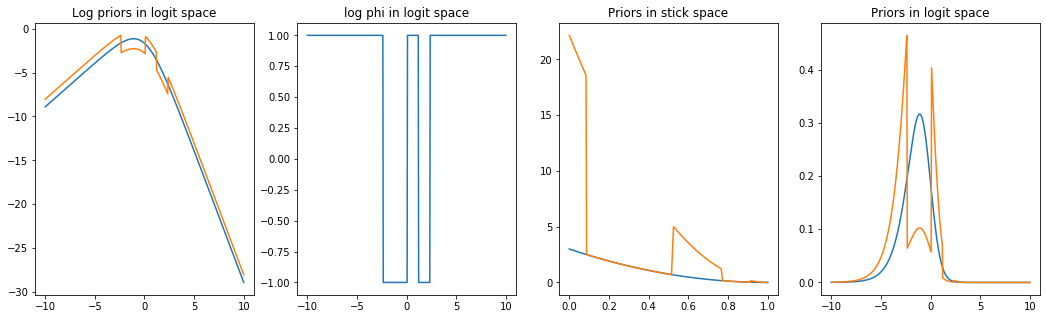

In [44]:
prior_perturbation.set_epsilon(1.0)

logit_v_grid = worst_case_pert.logit_v_grid
v_grid = sp.special.expit(logit_v_grid)

plt.figure(1, figsize=(18, 5))

plt.subplot(141)
plt.plot(logit_v_grid, prior_perturbation.get_log_p0_logit(logit_v_grid))
plt.plot(logit_v_grid, prior_perturbation.get_log_pc_logit(logit_v_grid))
plt.title('Log priors in logit space')

plt.subplot(142)
plt.plot(logit_v_grid, prior_perturbation.log_phi(logit_v_grid))
plt.title('log phi in logit space')

plt.subplot(143)
plt.plot(v_grid, np.exp(prior_perturbation.get_log_p0(v_grid)))
plt.plot(v_grid, np.exp(prior_perturbation.get_log_pc(v_grid)))
plt.title('Priors in stick space')

plt.subplot(144)
plt.plot(logit_v_grid, np.exp(prior_perturbation.get_log_p0_logit(logit_v_grid)))
plt.plot(logit_v_grid, np.exp(prior_perturbation.get_log_pc_logit(logit_v_grid)))
plt.title('Priors in logit space')


In [45]:
def get_e_log_perturbation(means, infos, epsilon): 
    return epsilon * worst_case_pert.get_e_log_linf_perturbation(means, infos)

In [50]:
def _hyper_par_objective_fun(params, epsilon): 
    
    means = params['ind_admix_params']['stick_means'].flatten()
    infos = params['ind_admix_params']['stick_infos'].flatten()
    
    return - get_e_log_perturbation(means, infos, epsilon)

# the terms of the KL objective that depend on epsilon 
hyper_par_objective_fun = paragami.FlattenFunctionInput(_hyper_par_objective_fun,
                                                        argnums=0, 
                                                        patterns=vb_params_paragami,
                                                        free = True)


# Get derivative for prior perturbation

In [51]:
epsilon_sens._set_cross_hess(hyper_par_objective_fun)
epsilon_sens._set_dinput_dhyper()

In [53]:
epsilon = 1.0
print('Epsilon: ', epsilon)

lr_vb_free_params = epsilon_sens.predict_opt_par_from_hyper_par(epsilon)

print('Predicted differences: ', np.linalg.norm(lr_vb_free_params - vb_opt))

Epsilon:  1.0
Predicted differences:  26.740133172944528


In [54]:
vb_pert_pred_dict = vb_params_paragami.fold(lr_vb_free_params, free = True)

In [33]:
new_init_dict = deepcopy(vb_opt_dict)
new_init_free = vb_params_paragami.flatten(new_init_dict, free = True)

In [34]:
optim_objective_pert, _ = \
    define_structure_objective(g_obs, new_init_dict,
                        vb_params_paragami,
                        prior_params_dict,
                        gh_loc = gh_loc,
                        gh_weights = gh_weights,
                        log_phi = log_prior_pert, 
                        epsilon = epsilon, 
                        compile_hvp=False)


Compiling objective ...
Iter 0: f = 7433.79796657
Compiling grad ...
Compile time: 12.9736secs


In [35]:
out = run_lbfgs(optim_objective_pert, new_init_free)

vb_opt_pert = out.x
vb_pert_dict = vb_params_paragami.fold(vb_opt_pert, free = True)


Running L-BFGS-B ... 
Iter 0: f = 7433.79796657
Iter 1: f = 7416.08530178
Iter 2: f = 7360.31339671
Iter 3: f = 7283.41486114
Iter 4: f = 7267.97888772
Iter 5: f = 7247.46325403
Iter 6: f = 7246.13648690
Iter 7: f = 7243.67361098
Iter 8: f = 7242.46173560
Iter 9: f = 7240.93466513
Iter 10: f = 7238.58219929
Iter 11: f = 7237.75982090
Iter 12: f = 7237.37548867
Iter 13: f = 7236.98876573
Iter 14: f = 7236.84120720
Iter 15: f = 7236.61778833
Iter 16: f = 7236.64848791
Iter 17: f = 7236.51874087
Iter 18: f = 7236.40456741
Iter 19: f = 7236.31071046
Iter 20: f = 7236.21694881
Iter 21: f = 7236.14292742
Iter 22: f = 7236.07774973
Iter 23: f = 7236.03484895
Iter 24: f = 7236.00987667
Iter 25: f = 7235.98665878
Iter 26: f = 7235.96907599
Iter 27: f = 7235.96097082
Iter 28: f = 7235.95160522
Iter 29: f = 7235.94733823
Iter 30: f = 7235.93671365
Iter 31: f = 7235.93053991
Iter 32: f = 7235.92284226
Iter 33: f = 7235.91207196
Iter 34: f = 7235.92580726
Iter 35: f = 7235.90837986
Iter 36: f = 72

In [36]:
np.linalg.norm(vb_opt_pert - vb_opt)

DeviceArray(25.49542812, dtype=float64)

### compare

In [37]:
def print_diff_plot(lr_vb_free_params, vb_opt_pert, vb_opt): 
    plt.plot((lr_vb_free_params - vb_opt), 
             vb_opt_pert - vb_opt, 
             '+', color = 'red')

    plt.plot(lr_vb_free_params - vb_opt, 
            lr_vb_free_params - vb_opt, 
             '-', color = 'blue')

    plt.xlabel('lr')
    plt.ylabel('re-optimized')


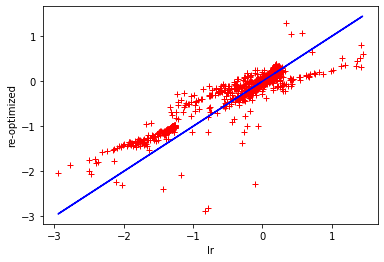

In [38]:
# compare free parameters
print_diff_plot(lr_vb_free_params, vb_opt_pert, vb_opt)

In [39]:
# compare expectations
init_e_ind_admix, init_e_pop_freq = plotting_utils.get_vb_expectations(vb_opt_dict, gh_loc, gh_weights)
pert_e_ind_admix, pert_e_pop_freq = plotting_utils.get_vb_expectations(vb_pert_dict, gh_loc, gh_weights)
lr_e_ind_admix, lr_e_pop_freq = plotting_utils.get_vb_expectations(
                                                    vb_params_paragami.fold(lr_vb_free_params, free = True), 
                                                    gh_loc, gh_weights)

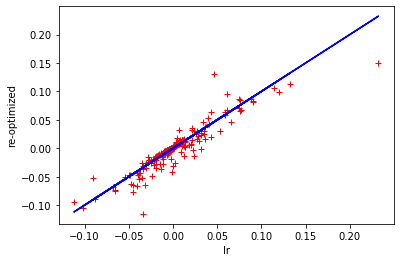

In [40]:
print_diff_plot(lr_e_ind_admix, pert_e_ind_admix, init_e_ind_admix)

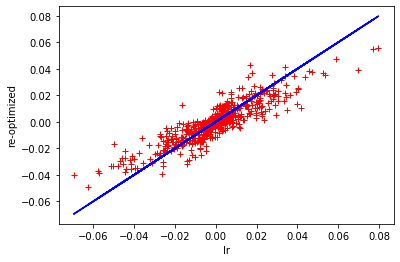

In [41]:
print_diff_plot(lr_e_pop_freq, pert_e_pop_freq, init_e_pop_freq)

In [42]:
print('init number of cluster: ', cluster_quantities_lib.get_e_num_clusters_from_ez(init_e_ind_admix))

print('pert number of cluster: ', cluster_quantities_lib.get_e_num_clusters_from_ez(pert_e_ind_admix))
print('lr number of cluster: ', cluster_quantities_lib.get_e_num_clusters_from_ez(lr_e_ind_admix))

init number of cluster:  5.577588359869459
pert number of cluster:  6.044130783860375
lr number of cluster:  5.6911500803824016


# Fit for a range of epsilon

In [44]:
epsilon_list = np.linspace(0, 1, 8) ** 2 # Square to get more points close to 0
print(epsilon_list)

[0.         0.02040816 0.08163265 0.18367347 0.32653061 0.51020408
 0.73469388 1.        ]


In [45]:
def refit_with_epsilon(epsilon, new_init_dict):
    # sets new epsilon, returns new vb optimum
    
    optim_objective_pert, new_init_free = \
        define_structure_objective(g_obs, new_init_dict,
                            vb_params_paragami,
                            prior_params_dict,
                            gh_loc = gh_loc,
                            gh_weights = gh_weights,
                            log_phi = log_prior_pert, 
                            epsilon = epsilon, 
                            compile_hvp=False)
    
    out = run_lbfgs(optim_objective_pert, new_init_free)
        
    return out.x


In [46]:
print('epsilons: ', epsilon_list)

epsilons:  [0.         0.02040816 0.08163265 0.18367347 0.32653061 0.51020408
 0.73469388 1.        ]


In [47]:
vb_pert_list = []
for epsilon in epsilon_list: 
    print('\n re-optimzing with epsilon = ', epsilon)
    
    vb_pert_list.append(refit_with_epsilon(epsilon, new_init_dict))



 re-optimzing with epsilon =  0.0
Compiling objective ...
Iter 0: f = 7551.80479680
Compiling grad ...
Compile time: 12.7022secs

Running L-BFGS-B ... 
Iter 0: f = 7551.80479680
Iter 1: f = 7553.88601523
Iter 2: f = 7551.80479229
done. Elapsed 0.175316secs
Iter 3: f = 7551.80479229
objective value:  7551.804792288652

 re-optimzing with epsilon =  0.02040816326530612
Compiling objective ...
Iter 0: f = 7549.39649414
Compiling grad ...
Compile time: 12.9256secs

Running L-BFGS-B ... 
Iter 0: f = 7549.39649414
Iter 1: f = 7549.67796477
Iter 2: f = 7549.34264582
Iter 3: f = 7549.32078048
Iter 4: f = 7549.30419307
Iter 5: f = 7549.30010406
Iter 6: f = 7549.29731387
Iter 7: f = 7549.29665668
Iter 8: f = 7549.29577172
Iter 9: f = 7549.29511239
Iter 10: f = 7549.29424768
Iter 11: f = 7549.29309228
Iter 12: f = 7549.29485639
Iter 13: f = 7549.29279403
Iter 14: f = 7549.29223970
Iter 15: f = 7549.29206672
Iter 16: f = 7549.29195310
Iter 17: f = 7549.29191200
Iter 18: f = 7549.29185531
Iter 19:

# Check free parameters

In [48]:
lr_list = []

for epsilon in epsilon_list: 
    
    # get linear response
    lr_list.append(epsilon_sens.predict_opt_par_from_hyper_par(epsilon))


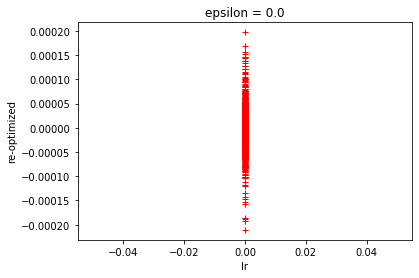

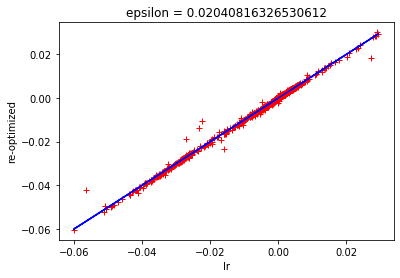

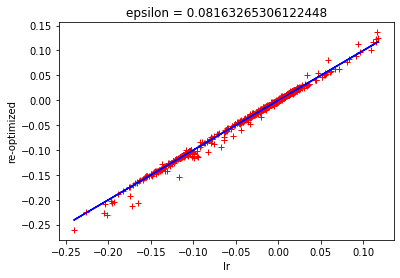

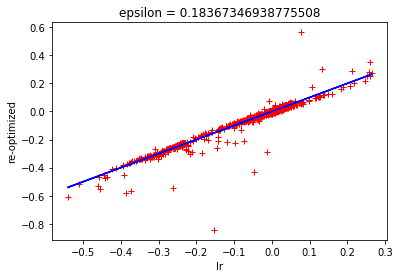

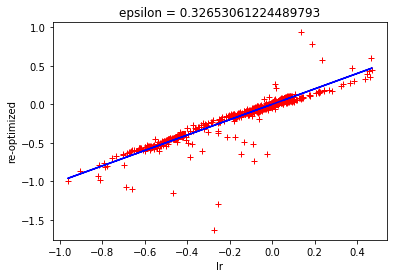

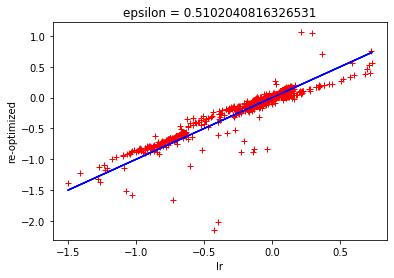

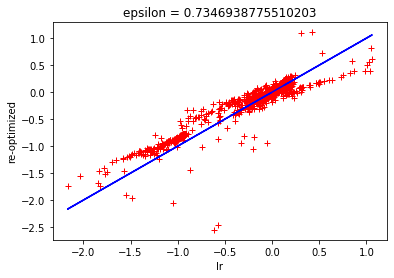

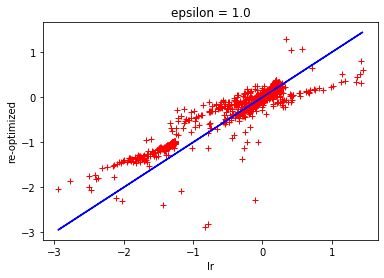

In [49]:
for i in range(len(epsilon_list)): 
    plt.figure()
    print_diff_plot(lr_list[i], vb_pert_list[i], vb_opt)
    
    plt.title('epsilon = {}'.format(epsilon_list[i]))


# Number of clusters

In [50]:
lr_e_num_clusters_vec = onp.zeros(len(epsilon_list))
refit_e_num_clusters_vec = onp.zeros(len(epsilon_list))

for i in range(len(epsilon_list)): 
    
    # get dictionaries
    pert_dict = vb_params_paragami.fold(vb_pert_list[i], free = True)
    lr_dict = vb_params_paragami.fold(lr_list[i], free = True)
    
    # get posterior expectations
    pert_e_ind_admix, pert_e_pop_freq = plotting_utils.get_vb_expectations(pert_dict, gh_loc, gh_weights)
    lr_e_ind_admix, lr_e_pop_freq = plotting_utils.get_vb_expectations(lr_dict, gh_loc, gh_weights)
    
    # get number of clusters
    refit_e_num_clusters_vec[i] = cluster_quantities_lib.get_e_num_clusters_from_ez(pert_e_ind_admix)
    lr_e_num_clusters_vec[i] = cluster_quantities_lib.get_e_num_clusters_from_ez(lr_e_ind_admix)


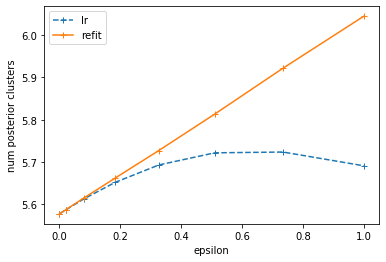

In [51]:
plt.plot(epsilon_list, lr_e_num_clusters_vec, '+--')
plt.plot(epsilon_list, refit_e_num_clusters_vec, '+-')

plt.xlabel('epsilon')
plt.ylabel('num posterior clusters')
plt.legend(('lr', 'refit'))
